Parte 1: Importações e Configurações Globais carregadas com sucesso.

Carregando imagens LIMPAS de 'fotos/Limpas'...

Carregando imagens SUJAS de 'fotos/Sujas'...

Parte 2: Carregamento concluído.

Total de imagens processadas (X): 39
Total de imagens originais sujas guardadas: 33
Shape de X: (39, 16384)
Distribuição de classes: [ 6 33] (0=Limpas, 1=Sujas)
Parte 4: PCA calculado.

Parte 5: Plotando amostras...


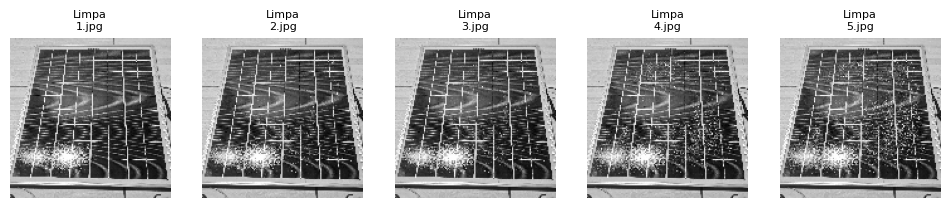


Parte 6: Plotando gráfico PCA...


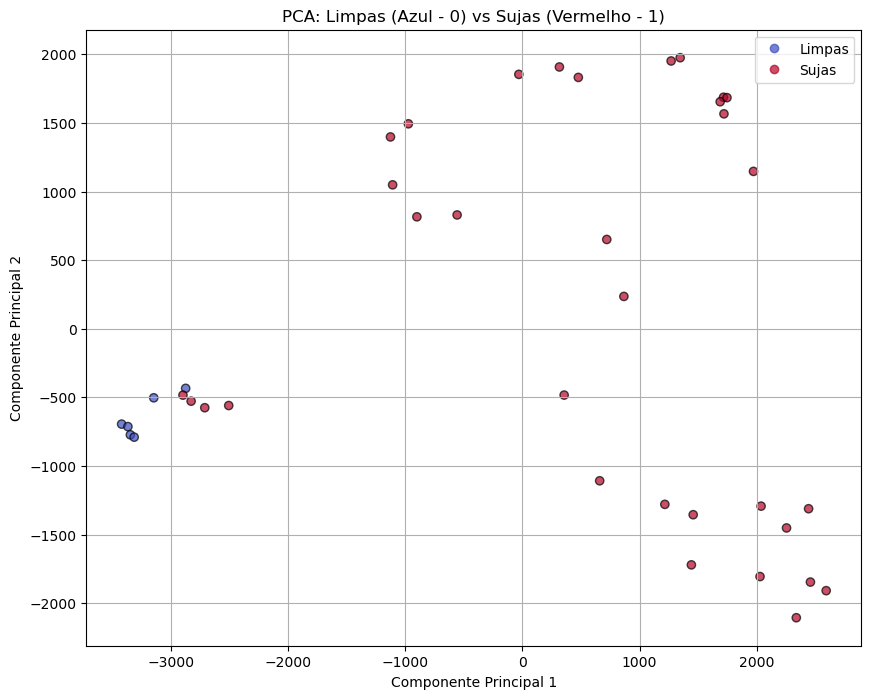


Parte 7: Aplicando filtro de cor marrom nas imagens sujas...


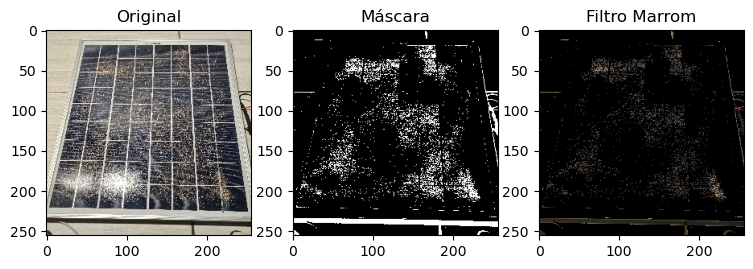

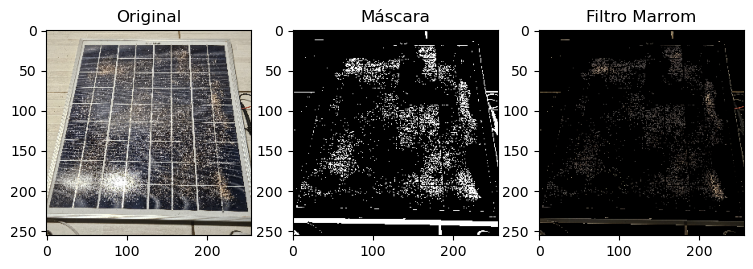

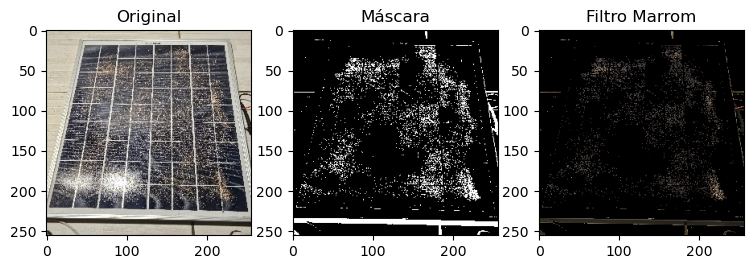


Parte 8: Treinando e Avaliando o SVM...
  Treinando modelo... (aguarde)

--- Resultados do SVM ---
Acurácia: 1.00 (100.00%)

Relatório de Classificação:
              precision    recall  f1-score   support

      Limpas       1.00      1.00      1.00         1
       Sujas       1.00      1.00      1.00        11

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



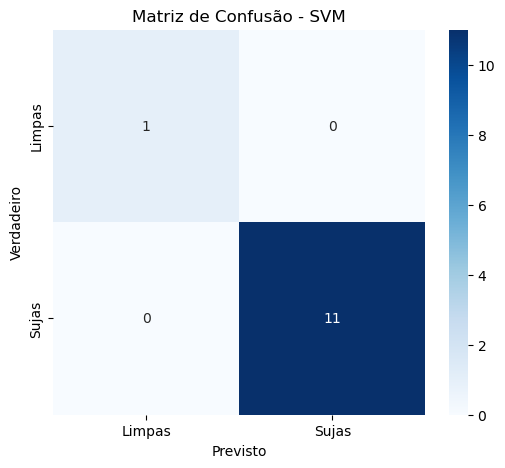

In [4]:
# ==================================================================================================
# PARTE 1: Importações e Definições de Configurações Globais
# ==================================================================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1.1 Configurações de Imagem e Arquivo ---
# Usando 128x128 para garantir performance rápida no treino do SVM
IMAGE_SIZE = (128, 128) 
FILE_EXTENSION = '.jpg'

print("Parte 1: Importações e Configurações Globais carregadas com sucesso.")

# ==================================================================================================
# PARTE 2: Inicialização e Carregamento de Imagens (Limpas e Sujas)
# ==================================================================================================

X_processed = []          
y = []                    
all_image_metadata = []   
original_color_images = [] # Guardaremos as sujas aqui (como LISTA)

# --- 2.1 Carregando Imagens LIMPAS (Classe 0) ---
limpas_dir = 'fotos/Limpas'
if os.path.exists(limpas_dir):
    print(f"\nCarregando imagens LIMPAS de '{limpas_dir}'...")
    for filename in os.listdir(limpas_dir):
        if filename.endswith(FILE_EXTENSION):
            image_path = os.path.join(limpas_dir, filename)
            img = cv2.imread(image_path)
            if img is not None:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                resized_img = cv2.resize(img_gray, IMAGE_SIZE)
                X_processed.append(resized_img.flatten())
                y.append(0) # Classe 0 = Limpas
                all_image_metadata.append({'filename': filename, 'class': 'Limpa'})
else:
    print(f"AVISO: Pasta '{limpas_dir}' não encontrada. O SVM precisa de duas classes para funcionar.")

# --- 2.2 Carregando Imagens SUJAS (Classe 1) ---
sujas_dir = 'fotos/Sujas'
print(f"\nCarregando imagens SUJAS de '{sujas_dir}'...")

if os.path.exists(sujas_dir):
    arquivos_sujos = [f for f in os.listdir(sujas_dir) if f.endswith(FILE_EXTENSION)]
    arquivos_sujos.sort() # Garante ordem
    
    for filename in arquivos_sujos:
        image_path = os.path.join(sujas_dir, filename)
        img = cv2.imread(image_path)
        
        if img is None:
            continue
        
        # Salva original colorida para o filtro marrom (Parte 7)
        # IMPORTANTE: Adiciona na lista sem processamento extra
        original_color_images.append(img) 
    
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img_gray, IMAGE_SIZE)
        X_processed.append(resized_img.flatten())
        y.append(1) # Classe 1 = Sujas
        all_image_metadata.append({'filename': filename, 'class': 'Suja'})
else:
    print(f"ERRO: Pasta '{sujas_dir}' não encontrada.")

print("\nParte 2: Carregamento concluído.")

# ==================================================================================================
# PARTE 3: Conversão para Arrays NumPy
# ==================================================================================================

X = np.array(X_processed)
y = np.array(y)

# --- CORREÇÃO AQUI ---
# Não convertemos original_color_images para np.array(..., dtype=object).
# Mantemos como lista Python pura para evitar o erro no cv2.resize.
# original_color_images = np.array(original_color_images, dtype=object) <--- REMOVIDO

if len(np.unique(y)) < 2:
    print("\nERRO CRÍTICO: Você precisa de imagens nas pastas 'Limpas' e 'Sujas' para treinar o SVM.")
else:
    print(f"\nTotal de imagens processadas (X): {len(X)}")
    print(f"Total de imagens originais sujas guardadas: {len(original_color_images)}")
    print(f"Shape de X: {X.shape}")
    print(f"Distribuição de classes: {np.bincount(y)} (0=Limpas, 1=Sujas)")

# ==================================================================================================
# PARTE 4: Aplicação de PCA (Para Visualização)
# ==================================================================================================

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X) 

print("Parte 4: PCA calculado.")

# ==================================================================================================
# PARTE 5: Plotagem (Visualização das Imagens)
# ==================================================================================================
print("\nParte 5: Plotando amostras...")

plt.figure(figsize=(12, 6))
# Plota as primeiras 5 imagens para conferência
qtd_plot = min(5, len(X))
for i in range(qtd_plot):
    plt.subplot(1, 5, i + 1)
    img_2d = X[i].reshape(IMAGE_SIZE)
    plt.imshow(img_2d, cmap='gray')
    plt.title(f"{all_image_metadata[i]['class']}\n{all_image_metadata[i]['filename']}", fontsize=8)
    plt.axis('off')
plt.show()

# ==================================================================================================
# PARTE 6: Gráfico PCA (Visualização da Separação)
# ==================================================================================================

print("\nParte 6: Plotando gráfico PCA...")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=y, 
    cmap='coolwarm', 
    alpha=0.7, 
    edgecolors='k'
)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA: Limpas (Azul - 0) vs Sujas (Vermelho - 1)')
plt.legend(handles=scatter.legend_elements()[0], labels=['Limpas', 'Sujas'])
plt.grid(True)
plt.show()

# ==================================================================================================
# PARTE 7: Filtro Marrom (Apenas nas imagens Sujas originais)
# ==================================================================================================

print("\nParte 7: Aplicando filtro de cor marrom nas imagens sujas...")

def detect_brown(image):
    # Converte para HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Definição de marrom (ajustado para detecção genérica de terra/poeira)
    lower_brown1 = np.array([0, 50, 20]); upper_brown1 = np.array([20, 255, 200])
    lower_brown2 = np.array([10, 50, 20]); upper_brown2 = np.array([40, 255, 200])
    lower_brown3 = np.array([0, 10, 10]); upper_brown3 = np.array([40, 150, 100])

    mask = cv2.inRange(hsv_image, lower_brown1, upper_brown1)
    mask = cv2.bitwise_or(mask, cv2.inRange(hsv_image, lower_brown2, upper_brown2))
    mask = cv2.bitwise_or(mask, cv2.inRange(hsv_image, lower_brown3, upper_brown3))

    return cv2.bitwise_and(image, image, mask=mask), mask

# Mostra apenas as 3 primeiras sujas para economizar espaço
if len(original_color_images) > 0:
    for i in range(min(3, len(original_color_images))):
        img_suja = original_color_images[i]
        
        # Verificação extra de segurança
        if img_suja is not None:
            # Como original_color_images é uma LISTA agora, img_suja é uma matriz direta (numpy array)
            # Não haverá erro de 'object' aqui.
            try:
                disp_img = cv2.resize(img_suja, (256, 256))
                res, mask = detect_brown(disp_img)
                
                plt.figure(figsize=(9, 3))
                plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(disp_img, cv2.COLOR_BGR2RGB)); plt.title("Original")
                plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("Máscara")
                plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)); plt.title("Filtro Marrom")
                plt.show()
            except Exception as e:
                print(f"Erro ao processar imagem {i}: {e}")

# ==================================================================================================
# PARTE 8: Classificação com SVM (Support Vector Machine)
# ==================================================================================================

print("\nParte 8: Treinando e Avaliando o SVM...")

if len(np.unique(y)) >= 2:
    # 1. Divisão Treino e Teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 2. Instanciando o SVM
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

    # 3. Treinamento
    print("  Treinando modelo... (aguarde)")
    svm_model.fit(X_train, y_train)

    # 4. Previsão
    y_pred = svm_model.predict(X_test)

    # 5. Métricas
    acc = accuracy_score(y_test, y_pred)
    print(f"\n--- Resultados do SVM ---")
    print(f"Acurácia: {acc:.2f} ({acc*100:.2f}%)")
    
    target_names = ['Limpas', 'Sujas']
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # 6. Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Matriz de Confusão - SVM')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()
else:
    print("Não foi possível treinar o SVM: dados insuficientes (necessário classe 0 e 1).")